# 언어모델 BERT

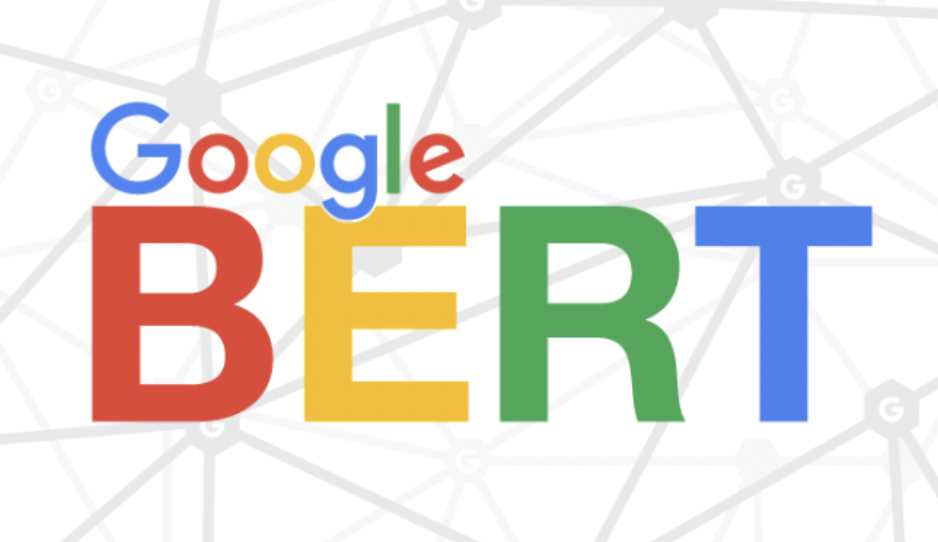

# **BERT : Pre-training of Deep Bidirectional Transformers for Language Understanding**

# - Bidirectional Encoder Representations from Transformers
# - 구글에서 개발한 NLP(자연어처리) 사전 학습 (pre-training) 기술
# - 사전 학습이란? 
    pre-train task - downstream task
    ex) 감정 분석 문제를 학습한 모델의 가중치를 텍스트 유사도 모델에 활용 (사전 학습된 가중치)
# - 특정 분야에 국한된 기술이 아니라 모든 자연어 처리 분야에서 좋은 성능을 내는 범용 Language Model

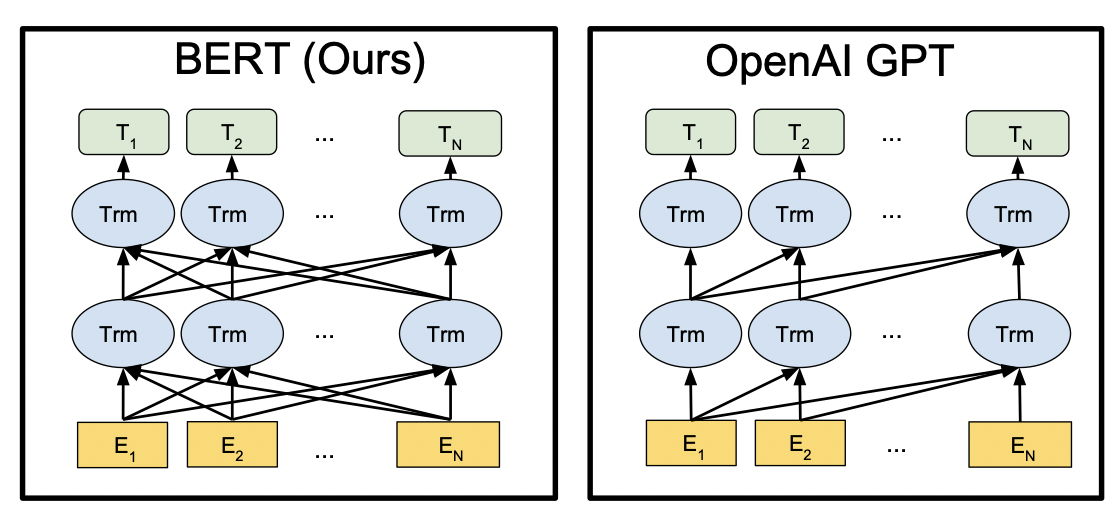

#- 기존의 사전 학습 모델인 GPT와 비교했을 떼, **양방향성**(bidirectional) 특징을 갖는다
#- Masked Language Modeling
#- 특정 단어를 가리고 앞뒤 상관없이 문장 안의 단어들을 모두 사용해서 가려진 단어를 예측


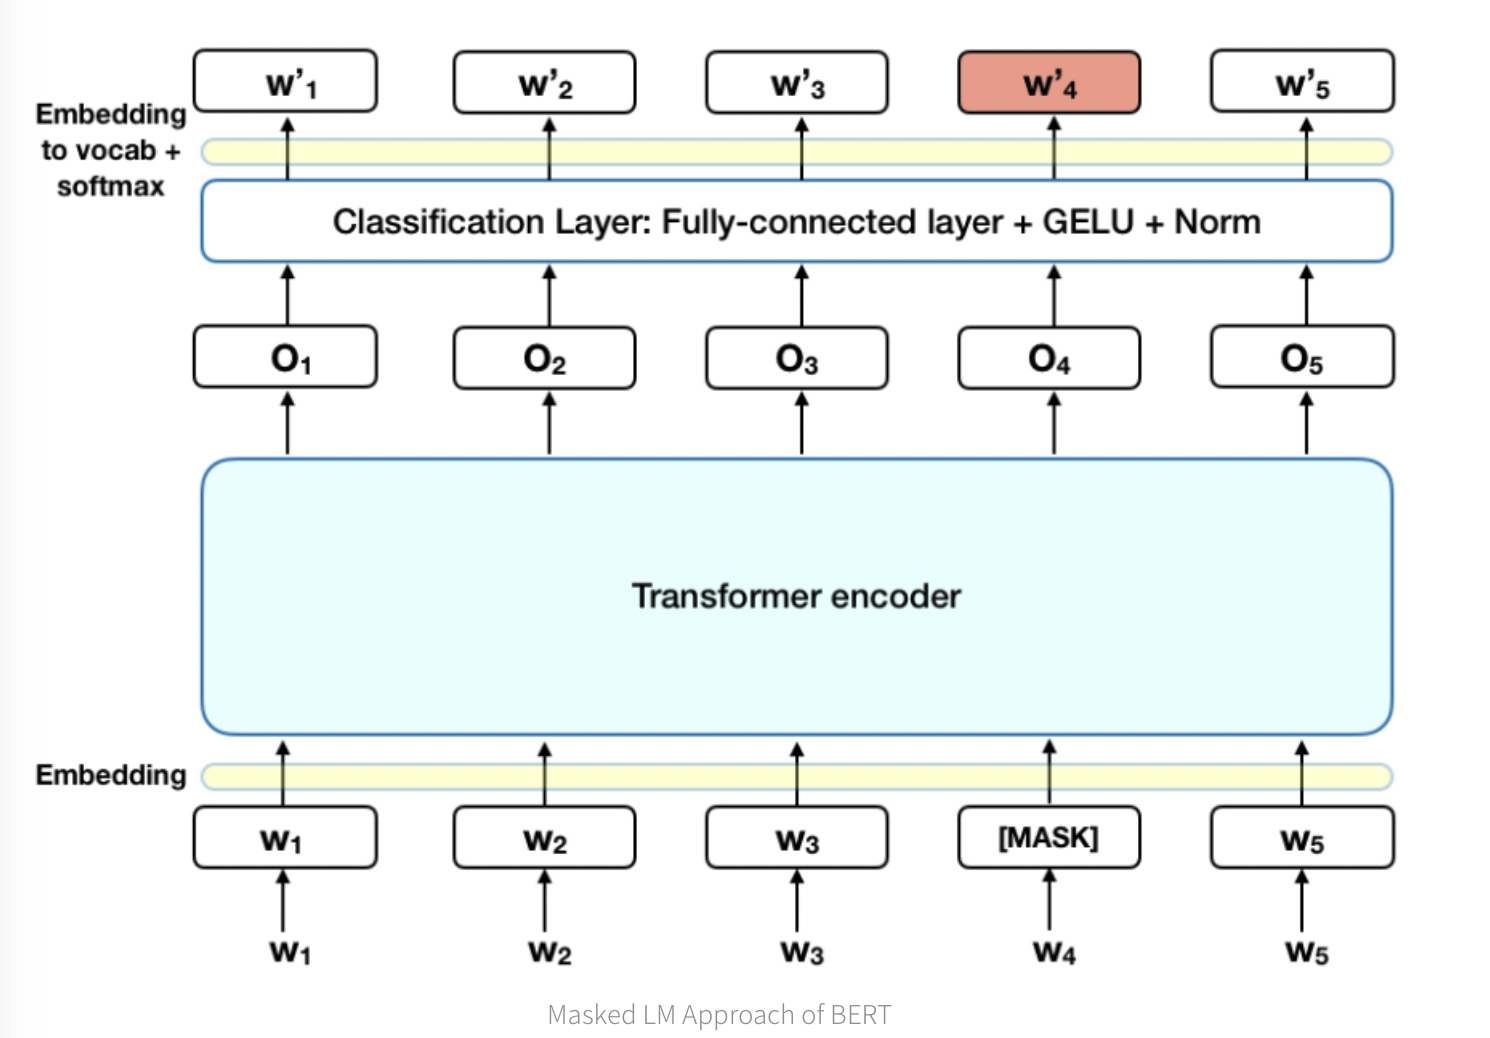


#1. Masked Language Modeling
- 80%는 [MASK] 매스킹을 하고
- 10%는 다른 단어로 치환하고
- 10%는 그대로 두고 transformer encoding
- -> 해당 매스킹을 예측(prediction)


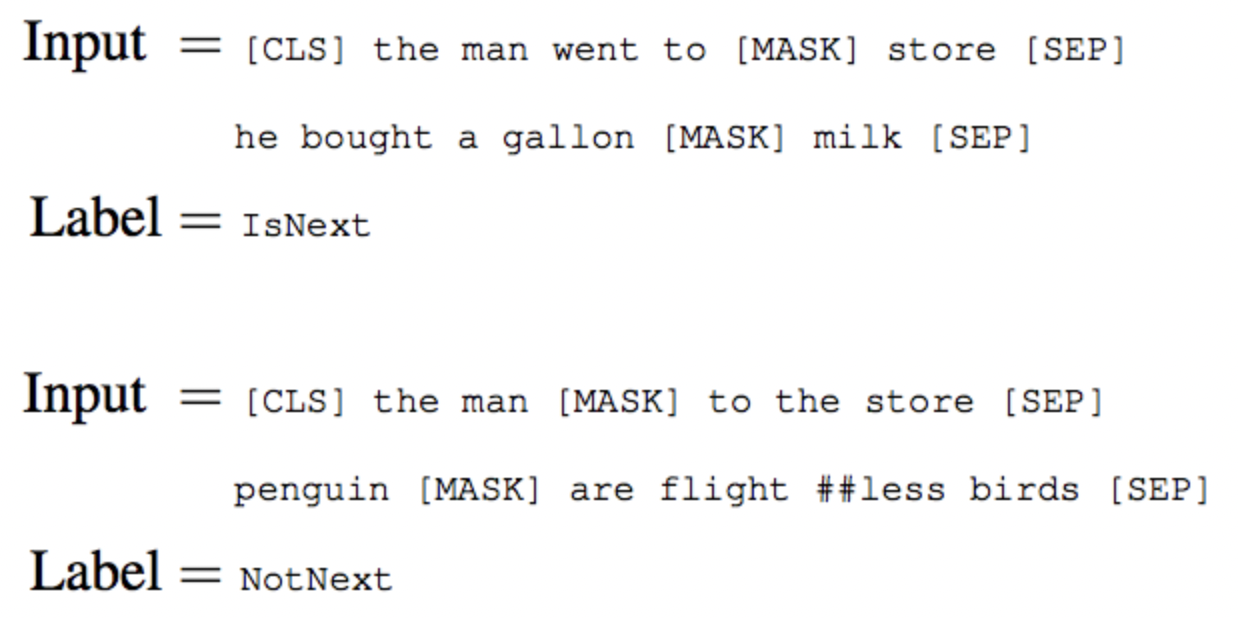

#2. Next Sentence Prediction

- Q&A 시스템을 만들거나 자연어 추론에 사용
- 대량 코퍼스에서 주어진 두 문장이 이어진 문장인지 예측하는 것을 학습
- [CLS] 다음 문장인지 여부
- [SEP] 문장이 종결되는 지점

# 토크나이저 테스트 & 버트를 활용한 미세 조정 학습

##버트의 미세조정 

사전 학습된 가중치를 가지고 있는 버트는 여러 하위 문제에 미세 조정(fine-tuning)될 수 있다. 

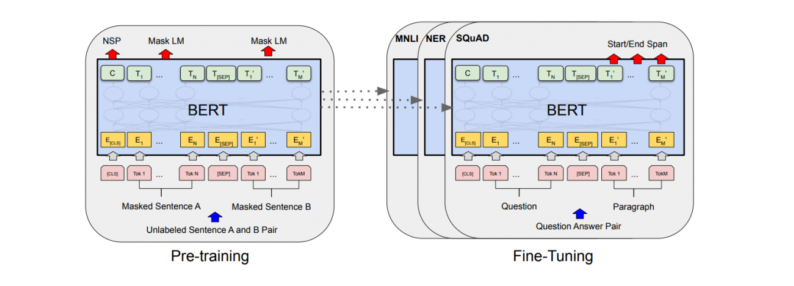

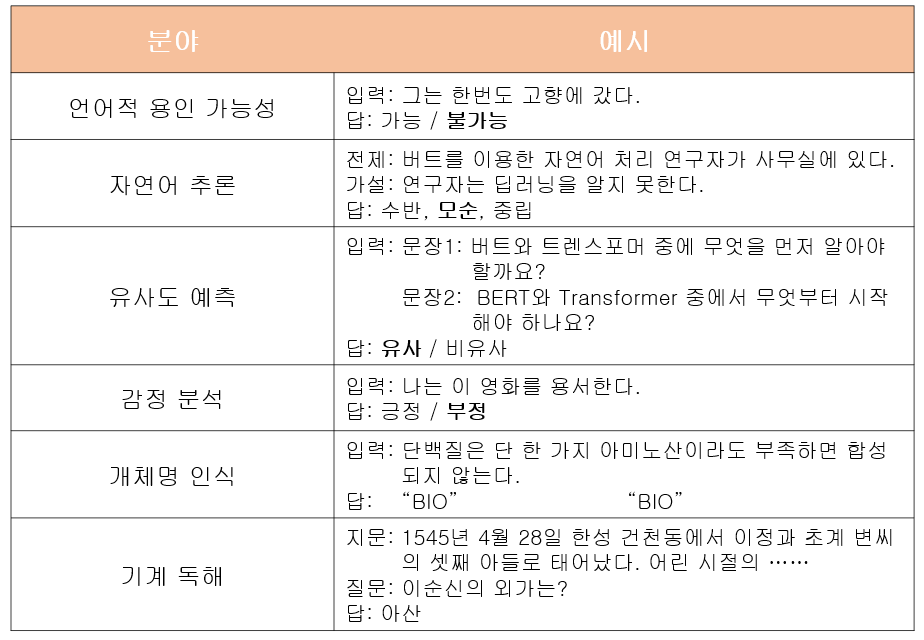

##허깅페이스의 트렌스포머 라이브러리 설치

In [ ]:
!pip install transformers==3.0.2

     |████████████████████████████████| 769 kB 3.9 MB/s 
     |████████████████████████████████| 1.2 MB 18.0 MB/s 
     |████████████████████████████████| 3.0 MB 27.4 MB/s 
     |████████████████████████████████| 895 kB 53.7 MB/s 


In [ ]:
from transformers import *
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', cache_dir='bert_ckpt', do_lower_case=False)

## 토크나이저 테스트

In [ ]:
test_sentence = "안녕하세요, 반갑습니다."

encode = tokenizer.encode(test_sentence)                                        # 문장이 토크나이징되고, 앞뒤에 스페셜 토큰 붙고, 토큰이 인덱스로 변화
token_print = [tokenizer.decode(token) for token in encode]

print(encode)
print(token_print)

In [ ]:
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다")
eng_encode = tokenizer.encode("Hello world")
kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
# [101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
print(eng_encode)
# [101, 31178, 11356, 102]
print(kor_decode)
# [CLS] 안녕하세요, 반갑습니다 [SEP]
print(eng_decode)
# [CLS] Hello world [SEP]

중국어 확인

In [ ]:
chi_encode = tokenizer.encode("我是韩国人。")
chi_decode = tokenizer.decode(chi_encode)
token_print = [tokenizer.decode(token) for token in chi_encode]


print(chi_encode)
print(chi_decode)
print(token_print)

##버트를 활용한 미세 조정 학습 

문장을 버트의 입력값으로 활용하기 위해서는 특정 분야(분류, 유사도, 추론 등)에 맞게 다양한 입력값으로 치환해야 한다. 버트 모델은 일반적으로 다음의 3가지 입력값을 받는다. (토크나이저를 통해 얻을 수 있음)

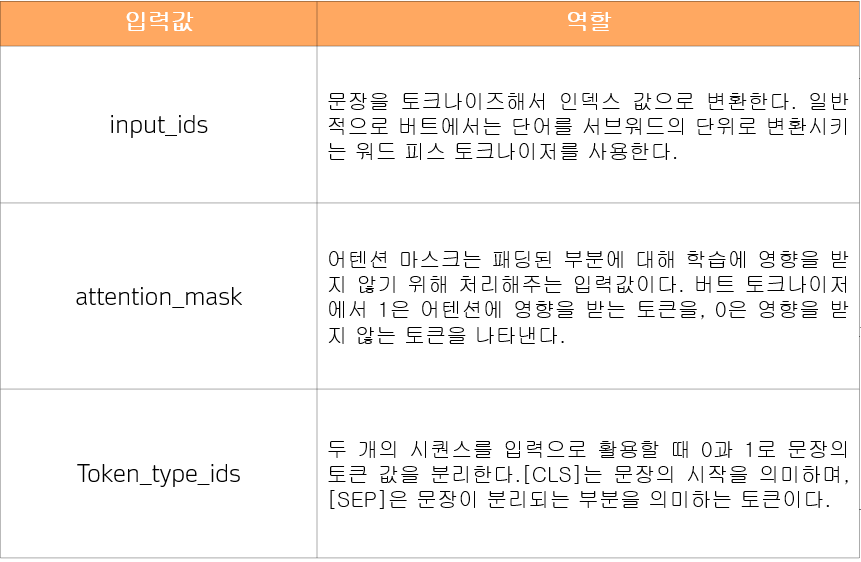

스페셜 토큰: 버트 토크나이저에서는 문장의 시작이나 끝, 모델별 목적에 맞게 스페셜 토큰을 활용한다. 각각의 역할은 다음과 같다. 

In [ ]:
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

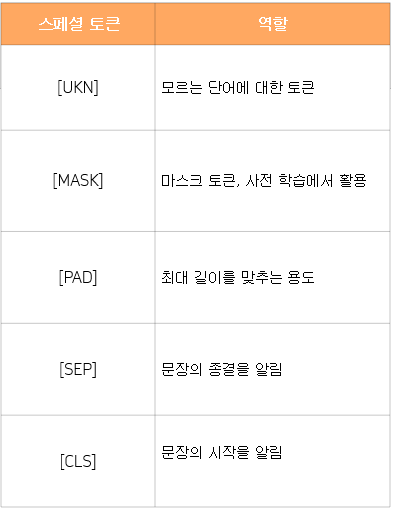

# 버트를 활용한 한국어 텍스트 분류 모델

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

###기본환경구성

In [ ]:
import os
import re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 39 # EDA에서 추출된 Max Length
DATA_IN_PATH = 'drive/MyDrive/data_in/KOR'                          # 데이터 경로 바꿔주기 
DATA_OUT_PATH = "drive/MyDrive/data_out/KOR"

In [ ]:
# 데이터 전처리 준비
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_train.txt")    #파일 불러올 경로 지정
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_test.txt")

train_data = pd.read_csv(DATA_TRAIN_PATH, header = 0, delimiter = '\t', quoting = 3)  # 경로, 헤더로 사용할 줄,탭 구분, 
train_data = train_data.dropna()                                                      # 결측치(값이 없는 빈칸)를 제거
train_data.head()                                                                     # 데이터 보기

In [ ]:
# 스페셜 토큰 보기
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# 토크나이저 테스트하기
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다. ")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)


print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)


In [ ]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           
        pad_to_max_length = True,       # 최대 길이 이하이면 패딩 적용 
        truncation = True,
        return_attention_mask = True   # 어텐션 마스크도 생성
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id                  # 세 값이 튜플 형식으로 반환

문장 예시

In [ ]:
sent="我喜欢看电影"
#MAX_LEN = 10

bert_tokenizer(sent, MAX_LEN)

전처리 시작

In [ ]:
# train_data = train_data[:1000] # for test

input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(train_data["document"], train_data["label"]), total=len(train_data)):      #학습 문장들에 대해  / tqdm: 진행률 보여줌(tatal: 전체 반복량)
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)      #세가지 입력값을 버트 토크나이저를 통해 구함. 
        
        input_ids.append(input_id)                                                        #각각을 아까 만든 빈리스트에 넣음
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:                                                           # 오류 발생 시 문장과 오류 내용 보여주고 다시 진행 재개 
        print(e)
        print(train_sent)
        pass

train_movie_input_ids = np.array(input_ids, dtype=int)                                            #정수 배열로 바꿔서
train_movie_attention_masks = np.array(attention_masks, dtype=int)
train_movie_type_ids = np.array(token_type_ids, dtype=int)
train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_type_ids)          #세가지를 튜플로 묶음 

train_data_labels = np.asarray(train_data_labels, dtype=np.int32)          #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_movie_input_ids), len(train_data_labels)))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

세 가지 입력값 예시 확인

In [ ]:
# 최대 길이: 39
input_id = train_movie_input_ids[1]
attention_mask = train_movie_attention_masks[1]
token_type_id = train_movie_type_ids[1]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

버트 분류 클래스 구성 

In [ ]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):                       # 모델 이름, 저장 장소, 정답 개수를 매개변수로 받음. 
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)                            # 사전 학습된 버트 모델 불러오기
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)                       # 드롭아웃 추가(과대적합을 막기 위함)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")                                        # 완전연결층(분류기) 하나 추가
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):       #__init__에서 선언한 내용을 실제 입력을 받고 실행하는 코드 
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',                           # 불러올 사전학습모델
                                  dir_path='bert_ckpt',                                           # 저장된 장소
                                  num_class=2)                                                    # 정답 개수 (긍부정-> 2)

In [ ]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-5)                            # 최적화
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)    # 손실값
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')           # 평가 기준 
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])                      # 우리가 만든 모델에 쌀아주기 

In [ ]:
model_name = "tf2_bert_naver_movie"                                                # 4장 참고

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)              # 모델 저장 (최적의 정확도를 내는 가중치만 저장)  verbose=1은 학습되는 동안 상황을 지켜보겠다

# 학습과 eval 시작
history = cls_model.fit(train_movie_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])                # 학습 후 좋은 성능의 모델이 저장됨.

#steps_for_epoch

print(history.history)

drive/MyDrive/data_out/KOR/tf2_bert_naver_movie -- Folder already exists 

Epoch 1/3
 271/3750 [=>............................] - ETA: 12:45:54 - loss: 0.4567 - accuracy: 0.7812

In [ ]:
plot_graphs(history, 'loss')

### Korean Movie Review Test 데이터

In [ ]:
test_data = pd.read_csv(DATA_TEST_PATH, header = 0, delimiter = '\t', quoting = 3)
test_data = test_data.dropna()
test_data.head()

In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sent, test_label in tqdm(zip(test_data["document"], test_data["label"])):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_movie_input_ids = np.array(input_ids, dtype=int)
test_movie_attention_masks = np.array(attention_masks, dtype=int)
test_movie_type_ids = np.array(token_type_ids, dtype=int)
test_movie_inputs = (test_movie_input_ids, test_movie_attention_masks, test_movie_type_ids)

test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(test_movie_input_ids), len(test_data_labels)))

테스트 결과 loss: 0.3375 - accuracy: 0.8593

In [ ]:
results = cls_model.evaluate(test_movie_inputs, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)